In [38]:
import vaex
from glob import glob
from os.path import join, abspath
from os import pardir
import numpy as np
from matplotlib import pyplot as plt
import sys

In [39]:
current = abspath('')
# import utils
root_dir = abspath(join(current, pardir))
if not root_dir in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/2_Cleaning',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [40]:
from utils import safe_mkdir

In [41]:
# root data directory
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [43]:
# Combine gaia with others
name = "Combine"
data_dir = join(root_data_dir, name)
safe_mkdir(data_dir)

Directory /home2/s20321005/Thesis-Project/Data/Combine already exist. Good to go!


In [44]:
# load Gaia-2MASS
name = "Gaia-2MASS-old"
gaia_dir = join(root_data_dir, name)
gaia_files = glob(join(gaia_dir, "*.hdf5"))
gaia_files.sort()
gaia_files[:5]

['/home2/s20321005/Thesis-Project/Data/Gaia-2MASS-old/gaia-000-001.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS-old/gaia-001-002.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS-old/gaia-002-003.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS-old/gaia-003-004.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS-old/gaia-004-005.hdf5']

In [45]:
gaia = vaex.open_many(gaia_files)
gaia

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,0.035724,-89.033127,15.052,14.149,UCU,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--
1,0.063679,-89.064964,16.05,14.818,ABB,4611985154309689728,22.728117,18.444002843809276,0.2338192,13.281042088032434,0.17243546,1.9008664677626548,0.14516754,18.659096,19.952793,17.509138,14.816096,92.14082,0.961987,1.434219,nan,nan,303.16646276195394,-28.03992520733377,3567.7712,3540.4517,3591.2698,4.8081,4.7134,4.8715,-0.5701,-0.7321,-0.4132,511.7533,482.8406,543.6623,0.5659,0.532,0.5969,nan,nan,nan,nan,nan,nan,nan,nan,nan,
2,0.065677,-89.440903,16.832,15.721,CCD,4611773979359229696,12.257193,10.270257194694619,0.5276517,-6.690335307418338,0.73907304,1.6194768785625475,0.46543595,20.19899,21.46941,18.940907,5.781402,32.732517,1.0632449,1.5661117,nan,nan,303.07168987844585,-27.673373331486737,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,
3,0.067073,-89.130386,15.453,14.788,AAB,4611972995259913856,6.025634,6.025590956511702,0.08982857,-0.022785710268113032,0.08030422,0.4389235852794528,0.065967396,17.134779,17.24778,16.258772,32.04953,42.694496,1.1276225,1.5967586,nan,nan,303.15001941439283,-27.976158120916963,5370.4893,5230.6763,5469.612,4.6165,4.5889,4.6439,-4.09,-4.1346,-3.9684,1469.2878,1397.0767,1547.8292,0.2059,0.114,0.2668,nan,nan,nan,nan,nan,nan,nan,nan,nan,unknown
4,0.073027,-89.090446,16.496,15.626,BCD,4611973334559675520,25.610413,16.575461579958816,0.34182423,19.52299381259894,0.28071013,1.592105289450467,0.2394431,19.371336,20.924316,18.204302,11.63563,72.14884,1.0419273,1.4066671,nan,nan,303.15991607268876,-28.01514667876553,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"470,994,547",359.810097,89.324234,14.997,14.232,AAA,2305750276576372992,8.857864,6.944159435779551,0.11212577,5.499127944254394,0.10824461,1.205446625880747,0.094102494,17.168484,18.000036,16.238264,72.4173,245.3936,1.5241516,1.3286858,nan,nan,122.76153347754278,26.469842071615023,4298.786,4278.832,4319.986,4.5658,4.5311,4.5965,-0.2744,-0.3633,-0.2046,770.3177,733.2712,814.6207,0.631,0.6054,0.6582,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"470,994,548",359.823644,89.644913,16.03,15.244,ACC,2305819541512528000,3.4697785,-3.342122996741894,0.119936794,0.9325107043887829,0.117376596,0.4851752777039695,0.10464805,17.959993,18.600903,17.200064,60.444508,90.97874,1.2257977,1.2494738,nan,nan,122.84219430111504,26.782347051064967,4269.341,4247.4688,4306.5337,4.8617,4.8323,4.8833,-1.2823,-1.3655,-1.1797,900.6884,867.4188,955.5297,0.0374,0.0109,0.0773,nan,nan,nan,nan,nan,nan,nan,nan,nan,
"470,994,549",359.843856,89.67437,15.542,14.9,ABB,2305819889406320896,9.0640955,-7.454146195987413,0.071599096,5.15689180333323,0.07226797,0.6795685788179534,0.061488032,17.302055,17.939072,16.520681,82.97307,178.90265,1.0247828,1.2678266,nan,nan,122.84974923386562,26.81102679181763,4885.6157,4807.968,5140.507,4.706,4.6177,4.7477,-0.8927,-1.0705,-0.488,990.8027,918.4789,1238.6727,0.5979,0.5382,0.7565,nan,nan,nan,nan,nan,nan,nan,nan,nan,F
"470,994,550",359.851795,89.1772,12.139,

In [ ]:
# gaia = (gaia_.filter("parallax > 0")
#                     .filter("e_parallax/parallax < 0.15")
#                     .filter("bpmag - rpmag > -3")
#                     .filter("bpmag - rpmag < 6")
#                     .filter("gmag > 3")
#                     .filter("gmag < 21")
#                     .filter("fb_over_err > 10")
#                     .filter("fr_over_err > 10")
#                     .filter("ruwe < 1.4")
#                     .filter("1.0+0.015*(bpmag - rpmag)**2 < excess_factor")
#                     .filter("1.3+0.06*(bpmag - rpmag)**2 > excess_factor")
#                     .filter("Jmag < 13.5")
#                     .filter("Jmag > 0")
#                )
# gaia

# RAVE6

In [47]:
name = "rave"
data_dir_rave = join(data_dir, name)
safe_mkdir(data_dir_rave)
data_dir_rave

Directory /home2/s20321005/Thesis-Project/Data/Combine/rave already exist. Good to go!


'/home2/s20321005/Thesis-Project/Data/Combine/rave'

In [48]:
# load RAVE
name = "RAVE6"
rave_dir = join(root_data_dir, name)
rave = vaex.open(join(rave_dir, "rave6.hdf5"))
rave

#,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,source_id
0,-37.893,4.791,3953.0,2.41,0.11,0.13,4973212867641442560
1,4.044,6.539,8286.0,4.91,0.39,0.0,4973250147957768832
2,-2.564,6.833,3813.0,2.89,0.38,0.38,4976544490953365632
3,77.837,1.993,4962.0,3.24,-0.61,0.07,4976851014178872448
4,3.519,4.035,4171.0,2.61,-0.14,0.19,4972468120311892096
...,...,...,...,...,...,...,...
"450,973",-0.753,1.277,5908.0,4.32,-0.01,0.11,6523116137833329792
"450,974",-1.839,2.183,5726.0,3.84,0.01,0.18,6523133145903856768
"450,975",7.603,1.202,3927.0,4.07,-0.41,0.0,6524623911873631104
"450,976",25.576,1.922,5654.0,4.33,0.05,0.19,6522142314129013504


In [49]:
rv = rave.dropnan(['rv_rave'])
rv

#,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,source_id
0,-37.893,4.791,3953.0,2.41,0.11,0.13,4973212867641442560
1,4.044,6.539,8286.0,4.91,0.39,0.0,4973250147957768832
2,-2.564,6.833,3813.0,2.89,0.38,0.38,4976544490953365632
3,77.837,1.993,4962.0,3.24,-0.61,0.07,4976851014178872448
4,3.519,4.035,4171.0,2.61,-0.14,0.19,4972468120311892096
...,...,...,...,...,...,...,...
"450,973",-0.753,1.277,5908.0,4.32,-0.01,0.11,6523116137833329792
"450,974",-1.839,2.183,5726.0,3.84,0.01,0.18,6523133145903856768
"450,975",7.603,1.202,3927.0,4.07,-0.41,0.0,6524623911873631104
"450,976",25.576,1.922,5654.0,4.33,0.05,0.19,6522142314129013504


In [50]:
has_gaia = rv.dropna(['source_id'])
has_gaia

#,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,source_id
0,-37.893,4.791,3953.0,2.41,0.11,0.13,4973212867641442560
1,4.044,6.539,8286.0,4.91,0.39,0.0,4973250147957768832
2,-2.564,6.833,3813.0,2.89,0.38,0.38,4976544490953365632
3,77.837,1.993,4962.0,3.24,-0.61,0.07,4976851014178872448
4,3.519,4.035,4171.0,2.61,-0.14,0.19,4972468120311892096
...,...,...,...,...,...,...,...
"450,973",-0.753,1.277,5908.0,4.32,-0.01,0.11,6523116137833329792
"450,974",-1.839,2.183,5726.0,3.84,0.01,0.18,6523133145903856768
"450,975",7.603,1.202,3927.0,4.07,-0.41,0.0,6524623911873631104
"450,976",25.576,1.922,5654.0,4.33,0.05,0.19,6522142314129013504


In [63]:
file = gaia_files[0]
gaia_clean = vaex.open(file)
gaia_pandas = gaia_clean.to_pandas_df()
gaia_pandas = gaia_pandas.drop_duplicates(subset=['source_id'])
gaia_clean = vaex.from_pandas(gaia_pandas)
gaia_clean

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,0.035724,-89.033127,15.052,14.149,UCU,999999,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--
1,0.063679,-89.064964,16.05,14.818,ABB,4611985154309689728,22.728117,18.444002843809276,0.2338192,13.281042088032434,0.17243546,1.9008664677626548,0.14516754,18.659096,19.952793,17.509138,14.816096,92.14082,0.961987,1.434219,nan,nan,303.16646276195394,-28.03992520733377,3567.7712,3540.4517,3591.2698,4.8081,4.7134,4.8715,-0.5701,-0.7321,-0.4132,511.7533,482.8406,543.6623,0.5659,0.532,0.5969,nan,nan,nan,nan,nan,nan,nan,nan,nan,
2,0.065677,-89.440903,16.832,15.721,CCD,4611773979359229696,12.257193,10.270257194694619,0.5276517,-6.690335307418338,0.73907304,1.6194768785625475,0.46543595,20.19899,21.46941,18.940907,5.781402,32.732517,1.0632449,1.5661117,nan,nan,303.07168987844585,-27.673373331486737,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,
3,0.067073,-89.130386,15.453,14.788,AAB,4611972995259913856,6.025634,6.025590956511702,0.08982857,-0.022785710268113032,0.08030422,0.4389235852794528,0.065967396,17.134779,17.24778,16.258772,32.04953,42.694496,1.1276225,1.5967586,nan,nan,303.15001941439283,-27.976158120916963,5370.4893,5230.6763,5469.612,4.6165,4.5889,4.6439,-4.09,-4.1346,-3.9684,1469.2878,1397.0767,1547.8292,0.2059,0.114,0.2668,nan,nan,nan,nan,nan,nan,nan,nan,nan,unknown
4,0.073027,-89.090446,16.496,15.626,BCD,4611973334559675520,25.610413,16.575461579958816,0.34182423,19.52299381259894,0.28071013,1.592105289450467,0.2394431,19.371336,20.924316,18.204302,11.63563,72.14884,1.0419273,1.4066671,nan,nan,303.15991607268876,-28.01514667876553,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"492,461",0.777458,89.107071,16.397,15.463,BCC,576317197316681984,5.8159885,4.6503373196196796,0.314001,3.4928617382547644,0.33658203,1.7270819258997259,0.28737998,19.328701,20.905706,18.16214,9.659323,32.614647,1.1007087,1.402335,nan,nan,122.72353403718911,26.255095559047387,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,
"492,462",0.79303,89.005005,16.193,15.835,ACD,576310497167602688,3.0507236,-1.6277612484209945,0.09963153,2.5801759820703984,0.09425513,0.25798121283314457,0.088577904,17.669441,18.12738,17.05587,132.23161,134.8385,1.0329734,1.216353,nan,nan,122.70014427105914,26.155008613983675,5038.1846,4905.743,5215.6826,4.7389,4.6908,4.8296,-1.0856,-1.6826,-0.6764,1517.0503,1269.1823,1767.5712,0.1314,0.0234,0.2368,nan,nan,nan,nan,nan,nan,nan,nan,nan,
"492,463",0.856221,89.263672,12.246,11.565,AAA,576413821198428416,37.931732,19.44744306501421,0.015040985,32.56705677323911,0.015052103,3.724639955853196,0.0133335395,13.971805,14.59627,13.216334,1213.5786,1659.5946,1.1046042,1.2521334,-45.57679,2.2679815,122.76109190279476,26.408014305717995,4456.6523,4443.9727,4465.4053,4.5275,4.5193,4.5314,-0.2331,-0.2478,-0.2198,276.0482,274.105,281.2514,0.1053,0.0917,0.1154,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"492,464",0.932587,89.725365,14.017,13.278,AAA,576451204593720832,12.769733,5.066254391491568,0.0382

In [66]:
# Join
cols = rave.column_names
for file in gaia_files:
    gaia_clean = vaex.open(file)
    gaia_pandas = gaia_clean.to_pandas_df()
    gaia_pandas = gaia_pandas.drop_duplicates(subset=['source_id'])
    gaia_clean = vaex.from_pandas(gaia_pandas)
    name = file.split("/")[-1]
    print(f"{name}, clean: {len(gaia_clean)}, raw: {len(gaia)}, {np.round(len(gaia_clean)/len(gaia)*100,2)}%")
    # join_rave = gaia_clean.join(rave, on="source_id", how="left")
    join_rave = rave.join(gaia_clean, on="source_id", how="inner")
    for col in cols:
        if col == "source_id": continue
        join_rave[col] = join_rave[col].to_pandas_series().to_numpy() # Do this to make np.nan value to no value
    join_rave.export(join(data_dir_rave, name), progress=True) # save the result if necessary
join_rave

gaia-000-001.hdf5, clean: 492466, raw: 470994552, 0.1%
export(hdf5) [########################################] 100.00% elapsed time  :     0.58s =  0.0m =  0.0h
 gaia-001-002.hdf5, clean: 479924, raw: 470994552, 0.1%
export(hdf5) [########################################] 100.00% elapsed time  :     0.51s =  0.0m =  0.0h  
 gaia-002-003.hdf5, clean: 483405, raw: 470994552, 0.1%
export(hdf5) [########################################] 100.00% elapsed time  :     0.72s =  0.0m =  0.0h
 gaia-003-004.hdf5, clean: 481163, raw: 470994552, 0.1%
export(hdf5) [########################################] 100.00% elapsed time  :     0.52s =  0.0m =  0.0h 
 gaia-004-005.hdf5, clean: 474070, raw: 470994552, 0.1%
export(hdf5) [########################################] 100.00% elapsed time  :     0.53s =  0.0m =  0.0h
 gaia-005-006.hdf5, clean: 472784, raw: 470994552, 0.1%
export(hdf5) [########################################] 100.00% elapsed time  :     0.50s =  0.0m =  0.0h
 gaia-006-007.hdf5, clean:

#,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,source_id,ra,dec,Jmag,Kmag,ph_qual,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,8.288,3.325,5923.0,4.22,0.03,0.09,6521984121893093120,359.347646,-51.051823,10.422,10.023,AAA,12.668094,12.606415461989814,0.014110323,-1.2485493970760204,0.018813001,2.0253342661952543,0.023791121,11.4876995,11.837173,10.971456,2549.1914,4154.6187,1.59564,1.2028177,6.876149,0.3219662,322.4887761098035,-63.9749588543307,5599.219,5595.8145,5606.192,4.0195,4.0156,4.0379,-0.2617,-0.2657,-0.2554,441.6703,427.4324,444.7439,0.002,0.0004,0.0056,0.1,0.07,0.11,-0.07,-0.09,-0.05,-0.01,-0.15,0.17,G
1,35.865,4.942,5265.0,3.83,-0.11,0.2,6523486295295829504,359.30781,-50.905987,9.509,9.194,AAA,43.99714,-43.917573416665334,0.0105391815,-2.644779226317138,0.015254995,4.688621066135538,0.018281069,10.429168,10.713454,9.980854,5122.2886,6013.2847,1.2607154,1.1942724,31.500162,0.20173362,322.6981357864998,-64.09119739985194,6130.4185,6127.3604,6133.428,4.2204,4.2181,4.2227,-0.2612,-0.2642,-0.2584,212.6671,211.848,213.5173,0.0534,0.0518,0.0549,-0.07,-0.09,-0.05,0.1,0.09,0.11,-0.06,-0.18,0.05,F
2,92.393,4.944,3500.0,3.89,-0.35,0.37,6523534570727611648,359.125072,-50.824467,12.153,11.865,AAA,4.645608,1.148099539170874,0.008900207,-4.501504219762659,0.0121954465,1.008798277618916,0.0143065555,12.961687,13.196701,12.578729,2778.5225,3203.3855,1.0132247,1.1830256,89.73567,1.5739497,323.018900083772,-64.10737933363484,6601.0566,6597.1406,6605.7583,4.087,4.0652,4.0959,-0.403,-0.4097,-0.4004,915.1139,904.5346,943.7161,0.1348,0.1327,0.1367,nan,nan,nan,nan,nan,nan,nan,nan,nan,F
3,-4.937,6.183,5010.0,2.94,0.25,0.12,6521814655365950464,359.820655,-52.165257,11.499,11.176,AAA,8.402637,6.7728411212212345,0.00824954,-4.973220188452688,0.010590728,1.8586586901511002,0.011185425,12.508627,12.834778,12.026952,2741.7722,2980.814,0.96530205,1.1930109,-4.5784125,0.68112296,320.7554370040214,-63.12055758880794,5715.781,5713.0356,5728.2954,4.233,4.227,4.2624,0.0148,0.0096,0.0252,515.5779,489.2572,520.9936,0.0019,0.0003,0.0088,0.42,0.3,0.51,-0.12,-0.2,-0.01,nan,nan,nan,G
4,16.98,1.96,3930.0,1.86,0.09,0.22,6521943886639416960,359.397258,-51.527576,9.318,8.248,AAA,4.0852675,4.050600372493842,0.014839239,-0.5310797920411615,0.018443218,0.36174603639798003,0.022853855,11.477964,12.353274,10.548148,680.5342,1236.7715,1.5081439,1.3149978,16.382627,0.19312622,321.92124411072336,-63.56949641211834,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.71,-0.74,-0.68,0.33,0.32,0.35,-0.07,-0.2,0.04,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,154",16.749,1.354,6188.0,4.36,-0.29,0.18,6521243257213155968,359.270764,-53.814087,10.953,10.633,AAA,2.0881202,-1.8475617215699687,0.010931785,0.9730166812796581,0.012890409,3.011896649706302,0.013406136,11.896255,12.187269,11.443655,2585.3135,2821.8074,1.076749,1.1933409,14.739625,0.5802492,319.82966022213276,-61.494748472768464,5884.4194,5883.2275,5886.222,4.2834,4.2792,4.2875,-0.3028,-0.3071,-0.2988,321.2733,319.801,322.7643,0.0005,1e-04,0.0014,-0.39,-0.48,-0.09,0.33,0.21,0.41,nan,nan,nan,G
"1,155",-7.977,2.043,6073.0,4.62,-0.02,0.1,6521828987673793024,359.476601,-52.100163,11.053,10.712,AAA,6.719543,-6.126314985244846,0.014323125,-2.7605299412980764,0.018121604,1.8487028845243303,0.019754454,12.04169

In [67]:
#quick look
quick = vaex.open_many(glob(join(data_dir_rave, "*.hdf5")))
quick

#,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,source_id,ra,dec,Jmag,Kmag,ph_qual,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,-20.169,4.304,4786.0,2.74,0.0,0.13,6286704164149086464,219.655143,-15.609369,8.892,8.188,AAA,3.4869146,-3.3411933891453067,0.01649509,-0.9974970637284706,0.01602046,1.1200994757563778,0.017629525,10.713037,11.356183,9.946146,1351.612,2639.611,1.0535316,1.2540983,-17.490528,0.18792775,337.442761534955,39.97298796216244,4821.99,4815.311,4828.8516,2.7016,2.6918,2.7183,0.1294,0.1248,0.1382,818.6559,804.6221,826.4486,0.5187,0.5143,0.5234,-0.12,-0.14,-0.09,-0.07,-0.08,-0.06,-0.12,-0.23,0.0,K
1,-5.47,5.046,3586.0,3.39,0.28,0.19,6286597404145785216,219.428628,-15.881729,10.127,9.7,AAA,66.31049,-28.412415097911598,0.02341032,-59.91507526728068,0.01935782,4.94758627029731,0.02447866,11.339757,11.71053,10.792753,1239.681,2500.6318,1.0376897,1.2120665,-7.3835917,0.6438819,337.01480157702827,39.85395669964236,5826.2544,5823.1206,5829.4536,4.3271,4.3234,4.3306,-0.37,-0.3751,-0.3652,196.8098,195.8612,197.8385,0.2988,0.2968,0.3007,-0.39,-0.71,-0.25,0.31,0.2,0.54,nan,nan,nan,G
2,-43.357,7.619,3554.0,3.65,0.11,0.31,6286686194006062464,219.978841,-15.672907,11.764,11.461,AAA,16.9606,-15.852125646610164,0.032846656,-6.030924256049547,0.03530048,1.769975628351585,0.036543038,12.850875,13.167588,12.365627,1033.8229,1926.6958,1.0687437,1.1998603,-35.03536,5.7990427,337.74464594092177,39.7551113916234,6046.0566,6026.6704,6066.797,4.0585,3.9909,4.0913,-0.6478,-0.669,-0.6153,611.1732,585.1034,682.5847,0.209,0.1993,0.2195,nan,nan,nan,nan,nan,nan,nan,nan,nan,F
3,7.884,8.275,6071.0,4.42,0.25,0.32,6286584420460998400,219.531666,-15.941563,12.08,11.765,AAA,17.028513,-16.37221488933462,0.024055624,-4.681970549186609,0.019292802,1.175410770929037,0.023686113,13.146798,13.455355,12.664797,1083.7788,2391.6287,1.4543347,1.2019814,11.916142,3.459665,337.0848482192867,39.7516213964895,6286.715,6249.9907,6320.5522,3.8508,3.8116,3.8761,-0.9599,-0.9836,-0.9351,974.7121,944.0793,1019.8837,0.2936,0.2787,0.309,nan,nan,nan,nan,nan,nan,nan,nan,nan,F
4,-24.085,5.951,3703.0,2.61,-0.14,0.21,6286539787160698240,219.08831,-16.416239,10.71,10.41,AAA,18.610386,-17.20030236846909,0.018120367,-7.106056657431765,0.015250095,3.0666761678521626,0.019017346,11.739696,12.055,11.2565155,1196.4572,2605.9785,1.0012422,1.1993114,-25.62343,1.7994858,336.2932713043729,39.56393958851663,5949.7466,5929.797,5969.75,4.2794,4.2643,4.2847,-0.326,-0.3453,-0.3056,323.4047,320.6097,332.4316,0.1396,0.1303,0.1499,-0.04,-0.19,0.16,0.15,-0.02,0.26,nan,nan,nan,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"446,446",10.279,1.292,6916.0,4.91,-0.18,0.01,4698007100072349824,33.274584,-66.470993,11.099,10.847,AAA,3.411009,-3.396302504265305,0.013535229,-0.3164057775317683,0.012364936,2.1708907057240783,0.010974484,11.925995,12.164117,11.53068,1439.1412,2449.5793,1.0232276,1.1882119,6.4449916,0.8410476,290.7561610937828,-48.681581032617586,6336.8643,6326.5786,6351.478,4.1359,4.1299,4.1421,-0.601,-0.6119,-0.5818,456.9001,454.1435,461.2156,0.041,0.0363,0.0473,-0.39,-0.56,-0.18,0.25,0.13,0.38,nan,nan,nan,F
"446,447",12.023,1.435,6536.0,4.78,-0.05,0.09,4694985775262614528,33.298097,-66.910156,11.002,10.731,AAA,3.6052144,3.443692683247644,0.01388185,1.067029172330035,0.013472734,2.188474466

check if something weird is going on with the data

In [68]:
gaia_filt = quick.filter("1000/parallax < 200")
gaia_filt = gaia_filt.extract()
gaia_filt

#,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,source_id,ra,dec,Jmag,Kmag,ph_qual,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,23.315,7.55,4861.0,3.82,0.43,0.18,6279741158872601472,219.29902,-21.462772,10.813,10.28,AAA,8.829687,-4.456678456054613,0.016397158,-7.622426557582301,0.01437679,5.399967227248751,0.016968826,12.189718,12.658676,11.556529,350.35767,518.80676,1.1756551,1.2250553,17.625717,0.99151164,333.35552366534074,35.08532122565192,5083.2163,5071.1226,5096.436,4.5249,4.5215,4.5284,-0.04,-0.0521,-0.0284,184.3435,183.759,184.8816,0.1432,0.1353,0.1517,0.34,0.22,0.51,0.05,-0.02,0.12,nan,nan,nan,K
1,4.595,3.969,3943.0,3.77,0.15,0.07,6278461400353723136,219.23623,-22.980255,10.657,9.828,AAA,61.378616,54.399044398700035,0.023156838,-28.426720501861524,0.020073142,11.403015818377257,0.02491186,12.7857275,13.694302,11.848829,648.648,1455.6438,1.278522,1.3117136,4.115794,1.5764862,332.41086076115084,33.78171343097785,4102.885,4100.6353,4105.471,4.6646,4.662,4.667,0.0113,0.0061,0.0175,87.4251,87.2716,87.5861,0.4293,0.4267,0.4316,-0.11,-0.24,0.01,0.2,0.14,0.23,nan,nan,nan,K
2,-32.878,5.865,3511.0,4.61,0.16,0.05,6325246822705992832,219.286324,-10.208799,10.651,9.79,AAA,58.034973,-47.1489143939437,0.020236012,-33.83841200631324,0.016182503,12.813278550682494,0.018085716,13.301383,14.624753,12.169109,646.4172,1020.11896,1.3463106,1.4086692,-24.342127,7.363014,340.98204230546685,44.712752830094516,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,M
3,-47.074,3.696,6210.0,4.77,0.41,0.0,6325188617309176576,219.127095,-10.478321,9.882,9.419,AAA,133.7423,-126.20814860153646,0.024667453,-44.254972045638894,0.022597065,6.324147521409492,0.02124536,11.208808,11.642476,10.612759,1479.5623,2489.812,1.0719355,1.2152487,-48.129185,0.7028729,340.5882115791573,44.57571339985151,5252.557,5238.435,5264.7456,4.4319,4.429,4.4351,0.1129,0.0981,0.1269,156.8375,156.1172,157.447,0.1105,0.1018,0.1181,0.45,0.42,0.48,-0.16,-0.19,-0.12,nan,nan,nan,G
4,24.821,4.09,3617.0,3.18,-0.09,0.29,6329843704727091328,219.296652,-9.06833,10.845,10.355,AAA,52.06572,-27.929734655436654,0.01869158,-43.94051928813335,0.017693762,5.431065248761104,0.018228613,12.189724,12.628875,11.584333,1155.5502,1602.761,1.1607513,1.2190963,19.798864,0.8691713,341.9035353979657,45.650239567425736,5298.42,5291.7573,5304.1064,4.6051,4.5994,4.6092,-0.1457,-0.1525,-0.1396,181.4655,180.8881,182.1471,0.1949,0.1907,0.1986,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"44,610",32.445,1.141,4678.0,4.77,0.06,0.0,4701482072212251648,33.922366,-62.531055,10.542,9.87,AAA,83.976654,83.84612064766912,0.027745534,4.680481645991509,0.02559462,8.04213090694351,0.022174722,12.276542,12.88738,11.497542,1647.9875,1970.7426,2.4217417,1.2757792,24.323425,0.6869116,287.3222249024561,-51.96822765710296,4525.195,4518.0405,4532.325,4.5901,4.5873,4.5924,0.1737,0.1584,0.1855,124.8147,124.5315,125.0407,0.1264,0.1194,0.1328,0.3,0.23,0.34,0.17,0.1,0.22,nan,nan,nan,K
"44,611",-1.008,1.143,5291.0,4.66,-0.05,0.0,4970655850272519424,33.921457,-32.887833,10.945,10.422,AAA,49.41114,45.97845788511303,0.011292988,-18.0953632952477,0.01727886,5.5604599556720435,0.017663524,12.235046,12.686164,11.624829,2008.7893,3394.9812,1.4107472,1.2170669,0.65

In [69]:
gaia_filt["GLON"] = gaia_filt["GLON"]*np.pi/180 - np.pi
gaia_filt["GLAT"] = gaia_filt["GLAT"]*np.pi/180
gaia_filt

#,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,source_id,ra,dec,Jmag,Kmag,ph_qual,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,23.315,7.55,4861.0,3.82,0.43,0.18,6279741158872601472,219.29902,-21.462772,10.813,10.28,AAA,8.829687,-4.456678456054613,0.016397158,-7.622426557582301,0.01437679,5.399967227248751,0.016968826,12.189718,12.658676,11.556529,350.35767,518.80676,1.1756551,1.2250553,17.625717,0.99151164,2.6765588140802787,0.6123543745074783,5083.2163,5071.1226,5096.436,4.5249,4.5215,4.5284,-0.04,-0.0521,-0.0284,184.3435,183.759,184.8816,0.1432,0.1353,0.1517,0.34,0.22,0.51,0.05,-0.02,0.12,nan,nan,nan,K
1,4.595,3.969,3943.0,3.77,0.15,0.07,6278461400353723136,219.23623,-22.980255,10.657,9.828,AAA,61.378616,54.399044398700035,0.023156838,-28.426720501861524,0.020073142,11.403015818377257,0.02491186,12.7857275,13.694302,11.848829,648.648,1455.6438,1.278522,1.3117136,4.115794,1.5764862,2.660071336080713,0.5896021263357537,4102.885,4100.6353,4105.471,4.6646,4.662,4.667,0.0113,0.0061,0.0175,87.4251,87.2716,87.5861,0.4293,0.4267,0.4316,-0.11,-0.24,0.01,0.2,0.14,0.23,nan,nan,nan,K
2,-32.878,5.865,3511.0,4.61,0.16,0.05,6325246822705992832,219.286324,-10.208799,10.651,9.79,AAA,58.034973,-47.1489143939437,0.020236012,-33.83841200631324,0.016182503,12.813278550682494,0.018085716,13.301383,14.624753,12.169109,646.4172,1020.11896,1.3463106,1.4086692,-24.342127,7.363014,2.8096666748151993,0.780384754515562,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,M
3,-47.074,3.696,6210.0,4.77,0.41,0.0,6325188617309176576,219.127095,-10.478321,9.882,9.419,AAA,133.7423,-126.20814860153646,0.024667453,-44.254972045638894,0.022597065,6.324147521409492,0.02124536,11.208808,11.642476,10.612759,1479.5623,2489.812,1.0719355,1.2152487,-48.129185,0.7028729,2.802793031945577,0.7779929652527645,5252.557,5238.435,5264.7456,4.4319,4.429,4.4351,0.1129,0.0981,0.1269,156.8375,156.1172,157.447,0.1105,0.1018,0.1181,0.45,0.42,0.48,-0.16,-0.19,-0.12,nan,nan,nan,G
4,24.821,4.09,3617.0,3.18,-0.09,0.29,6329843704727091328,219.296652,-9.06833,10.845,10.355,AAA,52.06572,-27.929734655436654,0.01869158,-43.94051928813335,0.017693762,5.431065248761104,0.018228613,12.189724,12.628875,11.584333,1155.5502,1602.761,1.1607513,1.2190963,19.798864,0.8691713,2.8257497633136897,0.7967469847757711,5298.42,5291.7573,5304.1064,4.6051,4.5994,4.6092,-0.1457,-0.1525,-0.1396,181.4655,180.8881,182.1471,0.1949,0.1907,0.1986,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"44,610",32.445,1.141,4678.0,4.77,0.06,0.0,4701482072212251648,33.922366,-62.531055,10.542,9.87,AAA,83.976654,83.84612064766912,0.027745534,4.680481645991509,0.02559462,8.04213090694351,0.022174722,12.276542,12.88738,11.497542,1647.9875,1970.7426,2.4217417,1.2757792,24.323425,0.6869116,1.8731261851137093,-0.9070166790424252,4525.195,4518.0405,4532.325,4.5901,4.5873,4.5924,0.1737,0.1584,0.1855,124.8147,124.5315,125.0407,0.1264,0.1194,0.1328,0.3,0.23,0.34,0.17,0.1,0.22,nan,nan,nan,K
"44,611",-1.008,1.143,5291.0,4.66,-0.05,0.0,4970655850272519424,33.921457,-32.887833,10.945,10.422,AAA,49.41114,45.97845788511303,0.011292988,-18.0953632952477,0.01727886,5.5604599556720435,0.017663524,12.235046,12.686164,11.624829,2008.7893,3394.9812,1.4107472,1.2170669,

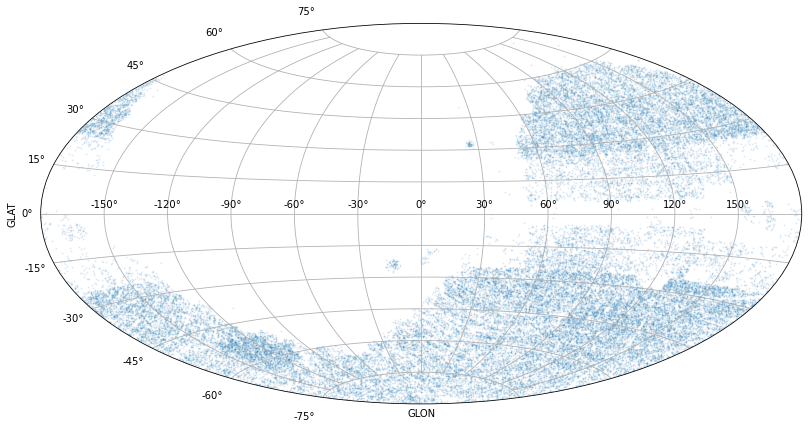

In [71]:
plt.figure(figsize=(14,7))
plt.subplot(111, projection='aitoff')
gaia_filt.viz.scatter("GLON", "GLAT", length_check=False, s=1, alpha=0.1)
plt.grid(True)
plt.show()

# GALAH

prereq: After joining with rave

In [74]:
name = "galah"
data_dir_galah = join(data_dir, name)
safe_mkdir(data_dir_galah)
data_dir_galah

Creating /home2/s20321005/Thesis-Project/Data/Combine/galah dir in Data dir


'/home2/s20321005/Thesis-Project/Data/Combine/galah'

In [75]:
name = "GALAH"
galah_dir = join(root_data_dir, name)
galah_files = glob(join(galah_dir, "*.hdf5"))
galah_files.sort()
galah = vaex.open_many(galah_files)
galah

#,source_id,teff_galah,e_teff_galah,logg_galah,e_logg_galah,feh_galah,e_feh_galah,alphafe_galah,e_alphafe_galah,rv_galah,e_rv_galah
0,4667368899326730240,4553.3545,137.06088556228917,4.7149534,0.20121636742743593,-0.33501863,0.12021913955493135,0.35136763119226394,0.07919326531297675,36.20399856567383,0.18299999833106995
1,4667362989451832320,3622.7446,104.98349008795871,4.6915054,0.19856208380453938,nan,nan,nan,nan,55.373325571289065,0.7317890322419305
2,4667324643983679488,4852.4756,172.75096900138723,2.4668846,0.22319904274460833,-1.1701574,0.18190171456363485,0.27304791329884204,0.0853664789169457,95.87799835205078,0.1509999930858612
3,4667335913977929728,5588.5005,104.29455501889545,3.9993572,0.18612670726590325,0.052394867,0.09937209372391331,-0.015429693609670742,0.05371322433644004,7.130000114440918,0.12600000202655792
4,4667323681911007232,5709.503,109.2033998665521,4.1819053,0.18470374660212685,-0.013732433,0.11137627470861318,0.08102261072159844,0.0803723809132596,24.81599998474121,0.16300000250339508
...,...,...,...,...,...,...,...,...,...,...,...
"588,056",6003344796319529984,4531.2153,71.12315268169422,2.4103317,0.18300246561395928,-0.29380798,0.04297140239160699,0.157507937659917,0.01185075698787861,58.42599868774414,0.05700000002980232
"588,057",6000435312445129728,6059.4995,89.92103435161873,3.5193155,0.1905389116378251,-0.04507351,0.09163415120321836,0.003646820192376051,0.04083085258215475,0.2770000100135803,0.10999999940395355
"588,058",6000421607212226560,4132.9727,83.45848117487678,0.95939153,0.3021431599031527,-1.003942,0.06525723837358276,0.1258948343706562,0.028202345502403702,37.00600051879883,0.06700000166893005
"588,059",6000420675196587008,4776.9272,98.42247509802459,2.4207969,0.22091855410307684,0.007314205,0.07383443001503355,-0.022905150506586088,0.0371291787455343,-69.5719985961914,0.0560000017285347


In [29]:
# Join with galah
cols = galah.column_names
for file in gaia_files:
    gaia_clean = vaex.open(file)
    gaia_pandas = gaia_clean.to_pandas_df()
    gaia_pandas = gaia_pandas.drop_duplicates(subset=['source_id'])
    gaia_clean = vaex.from_pandas(gaia_pandas)
    join_galah = galah.join(gaia, on="source_id", how="left")
    for col in cols:
        if col == "source_id": continue
        join_galah[col] = join_galah[col].to_pandas_series().to_numpy() # Do this to make np.nan value to no value
    name = file.split('/')[-1]
    join_galah.export(join(data_dir_galah, name), progress=True) # save if necessary
    a = join_galah.dropnan(["rv_galah"])
    print(f"saved {name} | {len(a)}")
    break
# sneak peek
# join_galah

export(hdf5) [########################################] 100.00% elapsed time  :     0.59s =  0.0m =  0.0h 
 saved gaia-000-001.hdf5 | 158


In [18]:
#quick look
quick = vaex.open_many(glob(join(data_dir_galah, "*.hdf5")))
quick

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,teff_galah,e_teff_galah,logg_galah,e_logg_galah,feh_galah,e_feh_galah,alphafe_galah,e_alphafe_galah,rv_galah,e_rv_galah
0,219.15519,-89.531815,11.418,10.704,AAA,5764635393079767296,11.202992,-8.352078761712255,0.012033119,-7.466580849038771,0.012214055,0.43047135125671315,0.011004682,13.174702,13.789571,12.425439,1228.2557,2930.1003,0.99114627,1.250944,67.09427,0.9067575,303.1640199013711,-26.708320393143175,4718.7,4713.292,4724.818,2.5833,2.5655,2.6014,-0.1946,-0.1952,-0.1941,2070.6995,2031.6134,2112.0928,0.3619,0.3574,0.3668,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,219.158806,-89.413895,11.663,11.294,AAA,5764640100363957504,17.092428,-15.001155516411039,0.012871818,-8.19246106070145,0.015000838,1.1756548246142724,0.013411725,12.782229,13.126454,12.259919,2108.8503,2770.0098,1.1272085,1.2091599,-44.15717,4.249649,303.2222502636439,-26.60253359940945,5956.387,5928.9277,5977.1416,3.7695,3.7597,3.7775,-0.5645,-0.585,-0.5521,867.1803,861.9395,874.5553,0.2911,0.2763,0.3022,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,219.247148,-89.488724,13.026,12.512,AAA,5764638554175708672,11.671728,-10.811040433849826,0.017244274,-4.3989353543881675,0.01951931,1.9674662903618854,0.01660323,14.446186,14.915824,13.815229,914.79407,1357.1978,0.9770324,1.2232119,13.169717,3.8980281,303.1861500960215,-26.669990195169934,5226.577,5217.9365,5235.52,4.5456,4.5418,4.5518,-0.1967,-0.2063,-0.1864,490.8246,487.5747,493.967,0.2623,0.2565,0.2679,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,219.781174,-89.569244,9.953,9.683,AAA,5764635079544432128,7.510926,1.5220681400491376,0.021005264,-7.355087608746858,0.020949371,2.877481398679552,0.018422326,10.847249,11.118501,10.412085,2177.0447,4133.433,1.3881594,1.1933558,-5.286206,0.73470575,303.150290423574,-26.744015581943707,6141.639,6130.1123,6152.07,4.043,4.0398,4.0469,-0.4365,-0.4457,-0.4269,344.0585,341.9788,346.0511,0.0799,0.0745,0.0847,-0.26,-0.32,-0.22,0.33,0.26,0.4,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,219.801943,-89.006889,12.509,11.912,AAA,5764731359829174400,11.346082,-10.54234747031648,0.016789988,-4.1943390093826975,0.015902767,0.2086716186891874,0.014617706,14.17896,14.733065,13.476229,735.02185,2048.8267,1.051371,1.2394285,42.34929,3.1309774,303.43352796578637,-26.242058683093564,5244.1147,5202.4478,5301.4165,3.1862,3.0736,3.2597,-0.1073,-0.1138,-0.1047,2680.891,2446.6587,3078.62,0.5634,0.538,0.5992,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"29,127,326",33.273628,89.207031,11.324,10.496,AAA,576401108095248256,1.9213098,0.526383419144043,0.013179262,-1.8477965023751626,0.012728541,0.4409312794625807,0.011253249,13.301876,14.039884,12.468293,817.5752,1747.642,1.0414628,1.2745866,-15.732807,0.7937079,123.2407090213187,26.38475107004395,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [22]:
a = quick.dropnan(["rv_galah"])
a

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,teff_galah,e_teff_galah,logg_galah,e_logg_galah,feh_galah,e_feh_galah,alphafe_galah,e_alphafe_galah,rv_galah,e_rv_galah
0,219.15734,-79.250374,12.739,12.401,AAA,5785465537792620544,3.699829,-3.6353896169663362,0.015797695,-0.6875153947196634,0.015386413,0.6943201200579083,0.012974283,13.881384,14.232967,13.361953,1352.151,1852.2777,0.9926711,1.2037885,8.874239,4.0331955,307.8999556033249,-17.40740814079525,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,6069.763,103.54831406919868,3.8796566,0.18815731746284703,-0.15020752,0.11378626427066946,0.004386986624897169,0.055993705030953744,56.952999114990234,0.1459999978542328
1,219.459462,-78.464539,10.968,10.265,AAA,5785572327860483072,12.00888,-9.194288980113411,0.012571546,-7.725168725999783,0.013220929,0.4102769628213485,0.0119091,12.704804,13.322832,11.959576,1569.1312,3681.9543,0.94684017,1.2466348,-26.75384,0.55700713,308.2963593477806,-16.716538910407706,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.3,0.25,0.39,-0.05,-0.11,-0.01,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,4608.3804,89.06553157198935,2.3247461,0.22973489965913393,-0.010188103,0.0646851243647423,0.10534814876645637,0.029025183901749668,-26.96299934387207,0.04800000041723251
2,219.584849,-77.401939,12.14,11.662,AAA,5785969388996924416,69.8985,-52.385182996537004,0.011761298,-46.277341178170154,0.012000477,1.0184034799656583,0.010924838,13.408228,13.804375,12.834604,1685.3644,3019.4504,1.0091081,1.2174528,179.89415,2.8840795,308.78129782794076,-15.76123302982826,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,5328.666,101.96428436153168,3.7090986,0.18513182212587664,-0.87820435,0.09539124793351698,0.01829620431316776,0.04846337805730739,178.53199768066406,0.14900000393390656
3,219.6097,-77.239639,11.328,10.865,AAA,5785984369843050496,10.159614,-6.819509429998995,0.010617121,-7.530740143314366,0.012268922,1.0238902282613678,0.009861224,12.516853,12.904768,11.960257,2290.958,3999.3142,0.9968179,1.2101759,-13.59087,4.1118073,308.8568600595925,-15.615815510735073,5832.0786,5819.583,5850.463,3.7024,3.6895,3.7115,0.0613,0.0505,0.076,930.0644,919.7898,946.0275,0.3394,0.3321,0.3496,0.27,0.17,0.47,-0.16,-0.25,-0.03,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,5666.058,84.15715440458767,3.5930886,0.18168406467785136,-0.37647438,0.06740703699662326,0.25158098147203484,0.060180721822081805,-33.79999923706055,0.1469999998807907
4,219.626036,-77.2761,12.447,12.024,AAA,5785972447013795840,5.328526,5.299399629505707,0.012745634,0.5563738626651364,0.013921545,0.9847344092213408,0.011771497,13.614826,14.000284,13.066026,1390.1344,2854.6382,0.9761048,1.2062962,-2.1756527,2.8162236,308.84456754294234,-15.650451291843003,5501.6636,5480.953,5512.856,4.1058,4.0993,4.1121,-0.0235,-0.0431,-0.0105,964.4503,953.7791,976.1446,0.1212,0.1096,0.1275,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,5728.292,102.45750929266949,4.05636,0.1844209735016198,0.43185616,0.09610704479239342,0.009681425973334089,0.05517082606994069,-0.40400001406669617,0.09099999815225601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# Lamost

prereq: galah and rave

In [32]:
name = "rave-galah-lamost"
data_dir_lamost = join(data_dir, name)
safe_mkdir(data_dir_lamost)
data_dir_lamost

Creating /home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost dir in Data dir


'/home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost'

In [33]:
name = "LAMOST"
lamost_dir = join(root_data_dir, name)
lamost_files = glob(join(lamost_dir, "*.hdf5"))
lamost_files.sort()
lamost = vaex.open_many(lamost_files)
lamost

#,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost,source_id
0,F9,5580.10009765625,110.20999908447266,4.593999862670898,0.1770000010728836,-0.01899999938905239,0.11599999666213989,26.200000762939453,9.449999809265137,0.1918340027332306,0.04679799824953079,2676865000324707584
1,G0,5719.72021484375,90.4000015258789,3.9660000801086426,0.14100000262260437,-0.23499999940395355,0.09399999678134918,1.7300000190734863,8.5600004196167,0.15432800352573395,0.050794001668691635,2676120459154270336
2,F6,5931.68994140625,95.66000366210938,4.370999813079834,0.15000000596046448,-1.0290000438690186,0.10000000149011612,15.5600004196167,8.869999885559082,0.189191997051239,0.051621001213788986,2676863969532562688
3,F5,6080.14990234375,39.88999938964844,4.144999980926514,0.05700000002980232,-1.024999976158142,0.035999998450279236,-24.649999618530273,5.5,0.1367579996585846,0.031055999919772148,2676876029800730368
4,F9,5576.39013671875,48.91999816894531,4.090000152587891,0.06700000166893005,0.36800000071525574,0.04600000008940697,-22.690000534057617,6.460000038146973,-0.08894199877977371,0.06206300109624863,2676925576543545856
...,...,...,...,...,...,...,...,...,...,...,...,...
"2,730,468",F2,5953.259765625,79.33000183105469,3.8310000896453857,0.12600000202655792,-0.23899999260902405,0.08399999886751175,23.84000015258789,6.980000019073486,0.21720999479293823,0.03240000084042549,1822777905628141696
"2,730,469",F5,6281.47021484375,75.88999938964844,4.21999979019165,0.11800000071525574,-0.17499999701976776,0.07900000363588333,0.2199999988079071,7.260000228881836,-0.06826099753379822,0.02922699972987175,1822773851178836608
"2,730,470",G5,5226.2998046875,46.45000076293945,3.0510001182556152,0.06700000166893005,-0.007000000216066837,0.04100000113248825,-13.65999984741211,6.360000133514404,-0.18201999366283417,0.08307900279760361,1822606450533050880
"2,730,471",G5,4736.02001953125,62.380001068115234,3.259000062942505,0.0989999994635582,-0.07599999755620956,0.06499999761581421,17.81999969482422,5.639999866485596,0.3313809931278229,0.05764999985694885,1822593668710339328


In [34]:
# let's say gaia + rave + galah is in the following path
files_join_galah = glob(join(data_dir_galah, "*.hdf5"))
files_join_galah.sort()
files_join_galah[:5]

['/home2/s20321005/Thesis-Project/Data/Combine/rave-galah/gaia-000-001.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah/gaia-001-002.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah/gaia-002-003.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah/gaia-003-004.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah/gaia-004-005.hdf5']

In [35]:
# Join with lamost
cols = lamost.column_names
for file in files_join_galah:
    gaia = vaex.open(file)
    join_lamost = gaia.join(lamost, on="source_id", how="left")
    for col in cols:
        if col == "source_id": continue
        join_lamost[col] = join_lamost[col].to_pandas_series().to_numpy() # Do this to make np.nan value to no value
    name = file.split('/')[-1]
    join_lamost.export(join(data_dir_lamost, name), progress=True) # save if necessary
    print(f"saved {name}")
# sneak peek
join_lamost

export(hdf5) [########################################] 100.00% elapsed time  :     0.80s =  0.0m =  0.0h
 saved gaia-000-001.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.92s =  0.0m =  0.0h
 saved gaia-001-002.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.76s =  0.0m =  0.0h
 saved gaia-002-003.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.97s =  0.0m =  0.0h
 saved gaia-003-004.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.82s =  0.0m =  0.0h 
 saved gaia-004-005.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.90s =  0.0m =  0.0h 
 saved gaia-005-006.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.90s =  0.0m =  0.0h
 saved gaia-006-007.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :  

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost
0,359.197673,-89.474236,12.984,12.515,AAA,6341106247145864192,2.1637506,-0.28364569025185976,0.015046449,2.1450785714295253,0.015701974,1.0190951201688359,0.01371227,14.296198,14.72302,13.696558,700.1737,699.5137,1.0162401,1.22074,8.857942,6.204644,303.0720608225402,-27.639054940686016,5768.1924,5746.9077,5781.7803,4.0546,4.0386,4.0687,-0.3619,-0.3787,-0.348,992.042,976.018,1007.1816,0.4224,0.4129,0.4283,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,359.348173,-89.053009,13.307,12.945,AAA,6341217950655102848,1.5533597,-0.47251260931759165,0.026276534,-1.4797494579065331,0.02079026,0.5743186220505488,0.017227173,14.593659,14.980516,14.033916,749.6103,1300.1835,1.0025918,1.2127099,62.051273,8.222315,303.1826826461763,-28.04879547717833,5690.552,5672.9004,5707.9634,4.0648,4.0566,4.0726,-0.6812,-0.7017,-0.6625,1461.9796,1435.8033,1489.4998,0.2952,0.2859,0.3044,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,359.733606,-89.062065,12.676,12.189,AAA,6341217847575888640,11.499268,11.350077713014269,0.02102051,1.8463210725828383,0.01658601,1.6000232255112057,0.013837926,13.979461,14.428928,13.369254,1022.7145,2021.0858,0.992757,1.2177873,-14.799017,3.0645275,303.17316762038894,-28.041469491933153,5249.8413,5201.954,5295.2095,4.3511,4.3325,4.363,-0.095,-0.1388,-0.0464,616.0235,609.1616,628.8472,0.1932,0.1624,0.2195,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,359.056727,-88.750359,12.964,12.57,AAA,6341247018993721984,5.0053473,4.903486948527943,0.01509401,1.004647899366386,0.016945133,0.7396490917262621,0.014090385,14.20839,14.603128,13.646724,1289.3406,1484.8617,1.0068202,1.2102869,15.164808,7.6442347,303.2706201607823,-28.341386168908638,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,359.233606,-88.75296,12.137,11.68,AAA,6341246950274245632,17.227442,17.127024694589473,0.01188792,1.8573534480699563,0.012567428,2.2335817333943186,0.010794495,13.358074,13.750389,12.799322,1184.8829,2186.8552,1.0227789,1.2095212,-11.014368,2.3281074,303.2656111884644,-28.33981089707305,5627.28,5621.009,5640.5483,4.4091,4.4049,4.413,-0.1841,-0.1911,-0.1722,436.8472,434.3726,441.0184,0.2367,0.2332,0.2438,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"42,500",359.121617,88.849464,12.791,12.414,AAA,2305490791832146432,4.029614,-0.8951470378522143,0.01455365,-3.92893117483260

In [36]:
#quick look
quick = vaex.open_many(glob(join(data_dir_lamost, "*.hdf5")))
quick

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost
0,219.15519,-89.531815,11.418,10.704,AAA,5764635393079767296,11.202992,-8.352078761712255,0.012033119,-7.466580849038771,0.012214055,0.43047135125671315,0.011004682,13.174702,13.789571,12.425439,1228.2557,2930.1003,0.99114627,1.250944,67.09427,0.9067575,303.1640199013711,-26.708320393143175,4718.7,4713.292,4724.818,2.5833,2.5655,2.6014,-0.1946,-0.1952,-0.1941,2070.6995,2031.6134,2112.0928,0.3619,0.3574,0.3668,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,219.158806,-89.413895,11.663,11.294,AAA,5764640100363957504,17.092428,-15.001155516411039,0.012871818,-8.19246106070145,0.015000838,1.1756548246142724,0.013411725,12.782229,13.126454,12.259919,2108.8503,2770.0098,1.1272085,1.2091599,-44.15717,4.249649,303.2222502636439,-26.60253359940945,5956.387,5928.9277,5977.1416,3.7695,3.7597,3.7775,-0.5645,-0.585,-0.5521,867.1803,861.9395,874.5553,0.2911,0.2763,0.3022,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,219.247148,-89.488724,13.026,12.512,AAA,5764638554175708672,11.671728,-10.811040433849826,0.017244274,-4.3989353543881675,0.01951931,1.9674662903618854,0.01660323,14.446186,14.915824,13.815229,914.79407,1357.1978,0.9770324,1.2232119,13.169717,3.8980281,303.1861500960215,-26.669990195169934,5226.577,5217.9365,5235.52,4.5456,4.5418,4.5518,-0.1967,-0.2063,-0.1864,490.8246,487.5747,493.967,0.2623,0.2565,0.2679,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,219.781174,-89.569244,9.953,9.683,AAA,5764635079544432128,7.510926,1.5220681400491376,0.021005264,-7.355087608746858,0.020949371,2.877481398679552,0.018422326,10.847249,11.118501,10.412085,2177.0447,4133.433,1.3881594,1.1933558,-5.286206,0.73470575,303.150290423574,-26.744015581943707,6141.639,6130.1123,6152.07,4.043,4.0398,4.0469,-0.4365,-0.4457,-0.4269,344.0585,341.9788,346.0511,0.0799,0.0745,0.0847,-0.26,-0.32,-0.22,0.33,0.26,0.4,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,219.801943,-89.006889,12.509,11.912,AAA,5764731359829174400,11.346082,-10.54234747031648,0.016789988,-4.1943390093826975,0.015902767,0.2086716186891874,0.014617706,14.17896,14.733065,13.476229,735.02185,2048.8267,1.051371,1.2394285,42.34929,3.1309774,303.43352796578637,-26.242058683093564,5244.1147,5202.4478,5301.4165,3.1862,3.0736,3.2597,-0.1073,-0.1138,-0.1047,2680.891,2446.6587,3078.62,0.5634,0.538,0.5992,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"29,127,326",33.273628,89.207031,11.324,10.496,AAA,57

# Apogee
prereq: rave + galah + lamost

In [37]:
name = "rave-galah-lamost-apogee"
data_dir_apogee = join(data_dir, name)
safe_mkdir(data_dir_apogee)
data_dir_apogee

Creating /home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost-apogee dir in Data dir


'/home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost-apogee'

In [38]:
name = "APOGEE-2"
apogee_dir = join(root_data_dir, name)
apogee_files = glob(join(apogee_dir, "*.hdf5"))
apogee_files.sort()
apogee = vaex.open_many(apogee_files)
apogee

#,source_id,rv_apogee,e_rv_apogee,teff_apogee,e_teff_apogee,logg_apogee,e_logg_apogee,mh_apogee,e_mh_apogee,alpham_apogee,e_alpham_apogee,feh_apogee,e_feh_apogee
0,0,9.257312,0.024030898,5694.8984,25.380983,4.4285197,0.019973632,0.0056574,0.0050330725,0.0066791,0.0065177004,0.0034626,0.0054009217
1,538028216707715712,-51.731453,0.020595735,3723.9111,4.0603027,0.9045983,0.021523084,-0.14768,0.0071834084,0.036922,0.0047346926,-0.16068,0.009251297
2,2413929812587459072,19.073862,0.038598746,5501.773,25.553564,4.304115,0.024554765,-0.26875,0.00675281,0.0909783,0.007372802,-0.27553,0.0072527267
3,422596679964513792,-20.545164,0.065306276,6099.781,45.84733,3.6739705,0.030661006,-0.2451,0.007007128,0.0291593,0.0117554255,-0.25297,0.007645966
4,4689447878791422208,165.67194,0.18812515,4555.4043,21.23888,1.4988511,0.08263534,-1.1832,0.01980606,0.008442001,0.025910037,-1.1714,0.021403484
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"573,728",6379920759951899648,153.94682,0.35605833,4487.381,18.90609,1.0601541,0.07097957,-1.2784,0.020431846,-0.025169,0.024306789,-1.2551,0.022141216
"573,729",1998097371124974720,-60.971943,0.02575837,4859.9087,9.050734,2.4806874,0.024013065,-0.22925,0.0063499245,0.065434,0.006152061,-0.23656,0.0073373728
"573,730",1994741318040223232,-56.44069,0.025619794,4585.4097,11.298859,2.571437,0.028686192,0.11992,0.009224876,0.037709,0.007181833,0.11482,0.011620254
"573,731",6379914575198998272,159.40576,0.32404962,4509.5913,18.433924,1.3348875,0.07705193,-1.0418,0.018824669,-0.019309998,0.02346231,-1.0505,0.020959308


In [39]:
# let's say gaia + rave + galah + lamost is in the following path
files_join_lamost = glob(join(data_dir_lamost, "*.hdf5"))
files_join_lamost.sort()
files_join_lamost[:5]

['/home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost/gaia-000-001.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost/gaia-001-002.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost/gaia-002-003.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost/gaia-003-004.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Combine/rave-galah-lamost/gaia-004-005.hdf5']

In [40]:
# Join with apogee
cols = apogee.column_names
for file in files_join_lamost:
    gaia = vaex.open(file)
    join_apogee = gaia.join(apogee, on="source_id", how="left")
    for col in cols:
        if col == "source_id": continue
        join_apogee[col] = join_apogee[col].to_pandas_series().to_numpy() # Do this to make np.nan value to no value
    name = file.split('/')[-1]
    join_apogee.export(join(data_dir_apogee, name), progress=True) # save if necessary
    print(f"saved {name}")

export(hdf5) [########################################] 100.00% elapsed time  :     1.07s =  0.0m =  0.0h
 saved gaia-000-001.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     1.29s =  0.0m =  0.0h
 saved gaia-001-002.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     1.04s =  0.0m =  0.0h 
 saved gaia-002-003.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     1.15s =  0.0m =  0.0h 
 saved gaia-003-004.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     1.04s =  0.0m =  0.0h 
 saved gaia-004-005.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     1.28s =  0.0m =  0.0h   
 saved gaia-005-006.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     1.09s =  0.0m =  0.0h  
 saved gaia-006-007.hdf5
export(hdf5) [########################################] 100.00% elapsed tim

In [41]:
# sneak peek
df_all = vaex.open_many(glob(join(data_dir_apogee, "*.hdf5")))
df_all

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost,rv_apogee,e_rv_apogee,teff_apogee,e_teff_apogee,logg_apogee,e_logg_apogee,mh_apogee,e_mh_apogee,alpham_apogee,e_alpham_apogee,feh_apogee,e_feh_apogee
0,219.15519,-89.531815,11.418,10.704,AAA,5764635393079767296,11.202992,-8.352078761712255,0.012033119,-7.466580849038771,0.012214055,0.43047135125671315,0.011004682,13.174702,13.789571,12.425439,1228.2557,2930.1003,0.99114627,1.250944,67.09427,0.9067575,303.1640199013711,-26.708320393143175,4718.7,4713.292,4724.818,2.5833,2.5655,2.6014,-0.1946,-0.1952,-0.1941,2070.6995,2031.6134,2112.0928,0.3619,0.3574,0.3668,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,219.158806,-89.413895,11.663,11.294,AAA,5764640100363957504,17.092428,-15.001155516411039,0.012871818,-8.19246106070145,0.015000838,1.1756548246142724,0.013411725,12.782229,13.126454,12.259919,2108.8503,2770.0098,1.1272085,1.2091599,-44.15717,4.249649,303.2222502636439,-26.60253359940945,5956.387,5928.9277,5977.1416,3.7695,3.7597,3.7775,-0.5645,-0.585,-0.5521,867.1803,861.9395,874.5553,0.2911,0.2763,0.3022,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,219.247148,-89.488724,13.026,12.512,AAA,5764638554175708672,11.671728,-10.811040433849826,0.017244274,-4.3989353543881675,0.01951931,1.9674662903618854,0.01660323,14.446186,14.915824,13.815229,914.79407,1357.1978,0.9770324,1.2232119,13.169717,3.8980281,303.1861500960215,-26.669990195169934,5226.577,5217.9365,5235.52,4.5456,4.5418,4.5518,-0.1967,-0.2063,-0.1864,490.8246,487.5747,493.967,0.2623,0.2565,0.2679,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,219.781174,-89.569244,9.953,9.683,AAA,5764635079544432128,7.510926,1.5220681400491376,0.021005264,-7.355087608746858,0.020949371,2.877481398679552,0.018422326,10.847249,11.118501,10.412085,2177.0447,4133.433,1.3881594,1.1933558,-5.286206,0.73470575,303.150290423574,-26.744015581943707,6141.639,6130.1123,6152.07,4.043,4.0398,4.0469,-0.4365,-0.4457,-0.4269,344.0585,341.9788,346.0511,0.0799,0.0745,0.0847,-0.26,-0.32,-0.22,0.33,0.26,0.4,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,219.801943,-89.006889,12.509,11.912,AAA,5764731359829174400,11.346082,-10.54234747031648,0.016789988,-4.1943390093826975,0.015902767,0.2086716186891874,0.014617706,14.17896,14.733065,13.476229,735.02185,2048.8267,1.051371,1.2394285,42.34929,3.1309774,303.43352796578637,-26.242058683093564,5244.1147,5202.4478,5301.4165,3.1862,3.0736,3.2597,-0.1073,-0.1138,-0.1047,2680.891,2446.6587,3078.62,0.5634,0.538,0.5992,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan

Look at each catalogs

In [42]:
df_rave = df_all[df_all.rv_rave.notnan()]
df_rave

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost,rv_apogee,e_rv_apogee,teff_apogee,e_teff_apogee,logg_apogee,e_logg_apogee,mh_apogee,e_mh_apogee,alpham_apogee,e_alpham_apogee,feh_apogee,e_feh_apogee
0,219.158866,-85.221237,9.079,8.368,AAA,5766698283052353280,8.785012,-6.506429489172309,0.011360749,5.9027808935617045,0.01175116,0.9676916643202073,0.010424577,10.879419,11.526657,10.109039,1519.6936,4017.2568,0.9663155,1.2553358,7.2354364,0.17830226,305.22704204485353,-22.825688146297875,4709.79,4704.5493,4717.3457,2.5309,2.5204,2.5499,0.1716,0.1703,0.1749,1025.6884,1004.9679,1037.2985,0.4296,0.4251,0.436,0.09,0.07,0.1,-0.11,-0.12,-0.1,-0.14,-0.29,-0.01,K,6.261,0.95,4558.0,2.08,-0.2,0.0,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,219.446032,-85.061722,8.777,8.038,AAA,5766712851582186368,9.162248,-8.526023979222124,0.011832091,3.354653882062056,0.011488983,1.192095806436178,0.010246603,10.472347,11.082486,9.729934,2582.2515,3904.8452,0.96463424,1.2474627,4.4096975,0.19387683,305.3251826400896,-22.69215040118779,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.07,-0.09,-0.04,-0.08,-0.09,-0.07,-0.12,-0.25,0.03,K,9.731,23.346,6314.0,2.44,0.46,0.2,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,219.180861,-83.383362,8.264,7.097,AAA,5770144393012705536,12.305981,-10.614177505055434,0.012931661,-6.227069466780825,0.015598092,0.253272081634179,0.012920153,10.823692,11.94718,9.780379,229.37637,462.51657,0.9851708,1.3580413,192.12454,0.26716965,306.0725349189872,-21.163410762745638,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,M,193.349,0.892,3917.0,1.46,-0.32,0.26,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,219.274742,-83.811623,8.599,7.931,AAA,5769940777203417216,12.849711,-11.219480047779893,0.017480757,-6.264051492439845,0.017432654,1.2219131710922218,0.014367744,10.269286,10.856883,9.545382,2185.1624,3091.6711,1.2090704,1.2420388,-8.578709,0.15804952,305.8874770226758,-21.555660077381255,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.02,0.01,0.04,-0.03,-0.03,-0.02,-0.09,-0.19,0.0,K,-7.232,1.57,4746.0,2.73,-0.15,0.08,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,219.706129,-83.743988,7.647,6.561,AAA,5769946858876419456,11.031818,-10.91562478437215,0.01630636,1.5969180508938725,0.01902428,0.6473746368964174,0.015077293,10.157426,11.254858,9.122177,707.96985,1316.0732,1.1045723,1.3561567,11.375745,0.14199287,305.9640826485769,-21.514599846565716,4850.095,4842.8955,4886.0825,1.5796,1.5683,1.6099,-1.0026,-1.038,-0.8738,1892.1688,1850.2239,1909.9314,1.8783,1.8727,1.9036,-0.22,-0.24,-0.21,0.17,0.17,0.18,-0.02,-0.11,0.05,M,12.312,0.717,3822.0,1.12,-0.32,0.12,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,

In [43]:
df_lamost = df_all[df_all.rv_lamost.notnan()]
df_lamost

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost,rv_apogee,e_rv_apogee,teff_apogee,e_teff_apogee,logg_apogee,e_logg_apogee,mh_apogee,e_mh_apogee,alpham_apogee,e_alpham_apogee,feh_apogee,e_feh_apogee
0,219.096657,-7.565882,11.686,11.34,AAA,6330335530022502784,17.146208,-14.170218037377232,0.019521624,-9.653879151799938,0.015527442,1.9112197726077607,0.01610834,12.701829,13.010178,12.226263,1514.8629,1340.8247,1.1783321,1.198208,24.736732,1.6587278,342.9128096290951,46.996043905557926,6168.611,6145.113,6185.352,4.3272,4.305,4.3652,-0.313,-0.3231,-0.3048,490.6344,464.2744,505.6615,0.1741,0.1623,0.1828,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,28.615,3.812,7713.0,4.67,0.48,0.0,nan,nan,nan,nan,nan,nan,nan,nan,F9,6069.330078125,61.790000915527344,4.206999778747559,0.0989999994635582,-0.010999999940395355,0.06499999761581421,22.059999465942383,5.269999980926514,-0.08982300013303757,0.0321430005133152,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,219.130886,-7.627661,11.2,10.752,AAA,6330331376789732224,34.65305,28.62940993490775,0.014779188,-19.52410310651999,0.013106218,4.380102422968465,0.014072866,12.496257,12.90566,11.917531,1451.8395,2180.57,1.1457552,1.2147049,-19.860388,1.1660893,342.9013985431985,46.925862349071,5448.9297,5430.4355,5461.7085,4.5753,4.5566,4.5944,-0.3355,-0.3511,-0.3224,223.0396,220.6569,224.4781,0.2026,0.1925,0.2104,-0.3,-0.77,-0.1,0.24,0.14,0.62,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,G6,5302.02001953125,53.2400016784668,4.499000072479248,0.0860000029206276,-0.36399999260902405,0.0560000017285347,-25.3700008392334,4.5,0.18034400045871735,0.05820399895310402,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,219.209638,-7.50144,11.122,10.771,AAA,6330356734276660736,27.14602,-20.880110253789184,0.019308528,-17.34726018477523,0.015150064,2.799420474638766,0.015758617,12.149782,12.457321,11.67323,1454.3212,2417.8596,1.1576707,1.199207,-34.015747,0.76648545,343.10138016498536,46.98390066619321,5710.082,5707.581,5714.78,4.3066,4.303,4.3099,-0.678,-0.6847,-0.6703,353.2261,351.4324,355.2636,0.0016,0.0004,0.0043,0.18,-0.19,0.34,0.16,-0.03,0.6,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,G0,6052.1298828125,41.130001068115234,4.366000175476074,0.061000000685453415,-0.25099998712539673,0.041999999433755875,-37.43000030517578,4.360000133514404,0.1253100037574768,0.03461400046944618,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,219.462083,-7.301673,11.639,11.25,AAA,6330367381499966592,5.4326425,-4.375683214523084,0.02268311,3.219782326677842,0.020886,1.5584985435093794,0.020379415,12.722058,13.069323,12.211807,858.24036,1222.5718,1.1751194,1.2001613,-28.459206,1.8016675,343.570352005323,47.000791980430364,5869.201,5863.3467,5875.359,4.1207,4.1133,4.1299,0.2631,0.2607,0.2674,635.2842,627.8944,641.3549,0.1722,0.1687,0.176,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,F9,5700.81005859375,58.790000915527344,3.990000009536743,0.09399999678134918,0.1889999955892563,0.06199999898672104,-30.899999618530273,5.139999866485596,-0.017578000202775,0.05088299885392189,nan,nan,nan,nan,nan,nan,nan,nan,na

In [44]:
df_apogee = df_all[df_all.rv_apogee.notnan()]
df_apogee

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost,rv_apogee,e_rv_apogee,teff_apogee,e_teff_apogee,logg_apogee,e_logg_apogee,mh_apogee,e_mh_apogee,alpham_apogee,e_alpham_apogee,feh_apogee,e_feh_apogee
0,219.237334,-73.656792,10.498,9.433,AAA,5796382897987441152,9.647704,-7.32525938112923,0.012122037,-6.278436730372129,0.013843336,0.1508087996249399,0.013381078,12.8519745,13.8142395,11.887843,608.2568,967.1161,1.1539006,1.3218985,-37.61812,0.58016646,310.28364498489213,-12.309942786939844,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.75,-0.86,-0.63,nan,nan,nan,nan,nan,nan,M,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-37.431576,0.020990571,3938.468,5.380895,1.0767968,0.028070316,-0.70227,0.008752569,0.31611502,0.007278086,-0.70026,0.010361035
1,219.012177,-73.178841,10.361,9.354,AAA,5796413993551100288,6.107945,1.939959300552022,0.010116944,-5.791679283603577,0.012221629,0.21981070260254718,0.010946967,12.636686,13.521186,11.713481,406.633,493.3874,1.0668205,1.3062522,67.80392,3.9128978,310.4204012331494,-11.846587246253742,4250.9634,4217.567,4286.313,0.7164,0.6953,0.7689,-1.3304,-1.3313,-1.33,8198.519,7800.3555,8419.999,0.6382,0.5951,0.6853,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,63.634853,0.02175037,4093.2874,5.7247305,1.3474834,0.026295902,-0.53778,0.0080171805,0.268205,0.006654908,-0.54629,0.009553526
2,219.017621,-73.30542,12.934,12.171,AAA,5796410591936952448,3.5906851,-3.361158891376779,0.018383548,1.263182828759949,0.019761112,0.1553578909693773,0.019689664,14.817099,15.481477,14.026341,909.3392,1999.684,0.96817046,1.2652911,-35.36883,5.7357306,310.36998070243476,-11.963121248383734,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-35.24056,0.049782094,4551.187,10.919033,2.0010319,0.035297208,-0.64854,0.010519041,0.330665,0.0102773905,-0.6446,0.012036176
3,219.063146,-73.281555,12.661,11.997,AAA,5796412103765449344,4.56673,-3.939254723198757,0.0154399965,-2.310259130741068,0.017295696,0.20371501964276173,0.017035898,14.360914,14.948166,13.629407,1305.119,1797.0538,0.93798214,1.2479345,11.54081,5.252177,310.39199480952385,-11.946534703630684,5345.5957,5334.5815,5394.9536,2.8802,2.8495,2.8895,-0.1587,-0.16,-0.1562,4966.726,4910.3,5172.242,0.7372,0.7295,0.7708,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.519653,0.052335467,4943.8193,16.585762,2.343202,0.03845342,-0.54899,0.010940283,0.27342498,0.011810059,-0.55632,0.012274511
4,219.117058,-73.14904,11.598,10.837,AAA,5796414130990057600,12.215473,-10.06025135006319,0.011257573,-6.928862693853749,0.014006137,0.32079736810405557,0.012589902,13.531725,14.208259,12.728591,1324.0776,1116.0614,1.0177226,1.27091,30.408573,1.3648496,310.46098700362364,-11.831492535697382,4735.2305,4712.7847,4746.2344,2.7309,2.7136,2.7467,0.1332,0.1141,0.1429,2600.387

In [45]:
df_galah = df_all[df_all.rv_galah.notnan()]
df_galah

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost,rv_apogee,e_rv_apogee,teff_apogee,e_teff_apogee,logg_apogee,e_logg_apogee,mh_apogee,e_mh_apogee,alpham_apogee,e_alpham_apogee,feh_apogee,e_feh_apogee
0,219.065565,-79.215218,12.48,12.067,AAA,5785466465505563904,1.3660686,0.41862546147359997,0.01515732,-1.3003446328426758,0.015462945,1.7373239336220865,0.012553155,13.6957855,14.059976,13.151965,1546.4104,1976.432,1.0744332,1.2131616,-32.621513,3.4649093,307.8988100863713,-17.368276591436405,5832.3125,5827.419,5837.3315,4.3903,4.3845,4.3947,-0.4976,-0.5031,-0.491,533.2805,529.7785,538.0505,0.2816,0.2788,0.2846,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,-33.22999954223633,0.10199999809265137,-0.4073739,0.08925589913977923,5695.1406,103.9081169095859,4.3403645,0.18512665539359374,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,219.113117,-79.296143,10.839,9.964,AAA,5785463819805688960,2.7192214,-0.8804132583557625,0.0140568465,-2.572749078180082,0.016808998,0.19310336007493623,0.013207236,12.847775,13.586003,12.013139,1198.3239,1940.1227,1.1638608,1.2753928,-15.133842,0.5786492,307.8723022034874,-17.445667918921284,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.23,-0.34,-0.11,0.21,0.1,0.32,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,-14.920999526977539,0.06300000101327896,-0.64509964,0.2734481426975921,4278.4927,90.37428905339947,1.5293067,0.256794876057159,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,219.15734,-79.250374,12.739,12.401,AAA,5785465537792620544,3.699829,-3.6353896169663362,0.015797695,-0.6875153947196634,0.015386413,0.6943201200579083,0.012974283,13.881384,14.232967,13.361953,1352.151,1852.2777,0.9926711,1.2037885,8.874239,4.0331955,307.8999556033249,-17.40740814079525,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,56.952999114990234,0.1459999978542328,-0.15020752,0.004386986624897169,6069.763,103.54831406919868,3.8796566,0.18815731746284703,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,219.181118,-79.057106,10.429,9.622,AAA,5785494949728838400,0.898941,-0.8537154372275574,0.0098404465,0.2815400304807175,0.012161774,0.3208527745309069,0.009572764,12.362253,13.068399,11.55194,1697.1932,2294.2537,1.0442461,1.2662963,9.800624,0.34132555,307.9878918077934,-17.233238409718094,4300.016,4238.75,4314.2954,1.774,1.6976,1.7968,-0.353,-0.3564,-0.3477,2771.9827,2710.7473,3025.2268,0.207,0.1328,0.2236,-0.36,-0.41,-0.3,-0.0,-0.02,0.02,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,10.52299976348877,0.052000001072883606,-0.27354622,0.1262540922078835,4360.825,79.60750589507889,1.8085941,0.22545058648640076,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,219.437037,-79.228142,11.715,11.109,AAA,5785465877090228352,18.960546,-13.020353551826815,0.01342858,-13.783060230149415,0.013252964,3.3509487357641894,0.0112121,13.220904,13.723639,12.558308,202.51959,291.21158,1.0535601,1.2313406,-0.5146209,3.1053522,307.9593662528928,-17.4088

In [46]:
df_gaia = df_all[df_all.rv_gaia.notnan()]
df_gaia

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,rv_rave,e_rv_rave,teff_rave,logg_rave,mh_rave,alphafe_rave,rv_galah,e_rv_galah,feh_galah,alphafe_galah,teff_galah,e_teff_galah,logg_galah,e_logg_galah,subclass_lamost,teff_lamost,e_teff_lamost,logg_lamost,e_logg_lamost,feh_lamost,e_feh_lamost,rv_lamost,e_rv_lamost,alpham_lamost,e_alpham_lamost,rv_apogee,e_rv_apogee,teff_apogee,e_teff_apogee,logg_apogee,e_logg_apogee,mh_apogee,e_mh_apogee,alpham_apogee,e_alpham_apogee,feh_apogee,e_feh_apogee
0,219.15519,-89.531815,11.418,10.704,AAA,5764635393079767296,11.202992,-8.352078761712255,0.012033119,-7.466580849038771,0.012214055,0.43047135125671315,0.011004682,13.174702,13.789571,12.425439,1228.2557,2930.1003,0.99114627,1.250944,67.09427,0.9067575,303.1640199013711,-26.708320393143175,4718.7,4713.292,4724.818,2.5833,2.5655,2.6014,-0.1946,-0.1952,-0.1941,2070.6995,2031.6134,2112.0928,0.3619,0.3574,0.3668,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,219.158806,-89.413895,11.663,11.294,AAA,5764640100363957504,17.092428,-15.001155516411039,0.012871818,-8.19246106070145,0.015000838,1.1756548246142724,0.013411725,12.782229,13.126454,12.259919,2108.8503,2770.0098,1.1272085,1.2091599,-44.15717,4.249649,303.2222502636439,-26.60253359940945,5956.387,5928.9277,5977.1416,3.7695,3.7597,3.7775,-0.5645,-0.585,-0.5521,867.1803,861.9395,874.5553,0.2911,0.2763,0.3022,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,219.247148,-89.488724,13.026,12.512,AAA,5764638554175708672,11.671728,-10.811040433849826,0.017244274,-4.3989353543881675,0.01951931,1.9674662903618854,0.01660323,14.446186,14.915824,13.815229,914.79407,1357.1978,0.9770324,1.2232119,13.169717,3.8980281,303.1861500960215,-26.669990195169934,5226.577,5217.9365,5235.52,4.5456,4.5418,4.5518,-0.1967,-0.2063,-0.1864,490.8246,487.5747,493.967,0.2623,0.2565,0.2679,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,219.781174,-89.569244,9.953,9.683,AAA,5764635079544432128,7.510926,1.5220681400491376,0.021005264,-7.355087608746858,0.020949371,2.877481398679552,0.018422326,10.847249,11.118501,10.412085,2177.0447,4133.433,1.3881594,1.1933558,-5.286206,0.73470575,303.150290423574,-26.744015581943707,6141.639,6130.1123,6152.07,4.043,4.0398,4.0469,-0.4365,-0.4457,-0.4269,344.0585,341.9788,346.0511,0.0799,0.0745,0.0847,-0.26,-0.32,-0.22,0.33,0.26,0.4,nan,nan,nan,F,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,219.801943,-89.006889,12.509,11.912,AAA,5764731359829174400,11.346082,-10.54234747031648,0.016789988,-4.1943390093826975,0.015902767,0.2086716186891874,0.014617706,14.17896,14.733065,13.476229,735.02185,2048.8267,1.051371,1.2394285,42.34929,3.1309774,303.43352796578637,-26.242058683093564,5244.1147,5202.4478,5301.4165,3.1862,3.0736,3.2597,-0.1073,-0.1138,-0.1047,2680.891,2446.6587,3078.62,0.5634,0.538,0.5992,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan